In [290]:
from qiskit import *
import numpy as np

from qiskit.visualization import plot_histogram
from qiskit import IBMQ, Aer
from scipy.optimize import minimize
from qiskit.providers.fake_provider import FakeToronto
import time

provider=IBMQ.load_account()
times = {
    "rx": {
        3: [],
        4: [],
        5: [],
        6: [],
    },
    "ry": {
        3: [],
        4: [],
        5: [],
        6: [],
    }
}

ibmqfactory.load_account:WARNING:2022-12-04 23:29:55,433: Credentials are already in use. The existing account in the session will be replaced.


In [291]:
def QAOA_Vertex_Cover(connections,gamma,beta):
    n=max(map(max, connections))+1
    qc=QuantumCircuit(n+1,n)


    qc.x(n)
    qc.h(range(n))
    
    
    qc.barrier()
    for i in connections:
        qc.cp(-1*gamma,i,n)
        qc.mcp(gamma,i,n)

        
    qc.barrier()


    for i in range(n):
        qc.x(i)
        qc.cp(-1*gamma,i,n)
        qc.x(i)


    qc.barrier()


    qc.rx(2*beta, range(n))


    qc.measure(range(n),range(n))

    return qc

def QAOA_Vertex_Cover_ry(connections,gamma,beta):
    n=max(map(max, connections))+1
    qc=QuantumCircuit(n+1,n)


    qc.x(n)
    qc.h(range(n))
    
    
    qc.barrier()
    for i in connections:
        qc.cp(-1*gamma,i,n)
        qc.mcp(gamma,i,n)

        
    qc.barrier()


    for i in range(n):
        qc.x(i)
        qc.cp(-1*gamma,i,n)
        qc.x(i)


    qc.barrier()


    qc.ry(2*beta, range(n))


    qc.measure(range(n),range(n))

    return qc




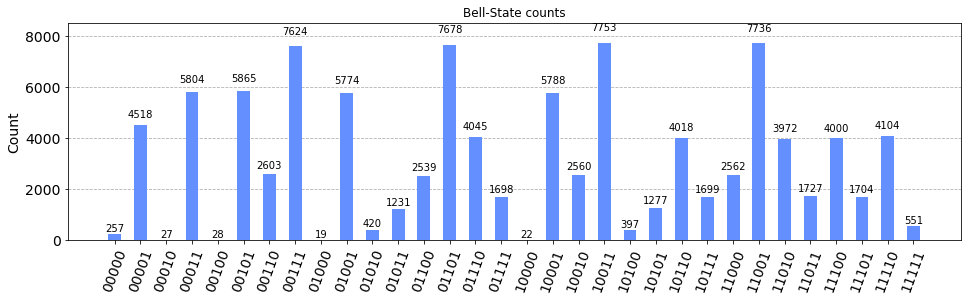

In [292]:
connections=[[0,1],[0,2],[0,3],[0,4],[1,3],[2,4]]
#gamma=[0,2pi], beta=[0,pi], gamma1<gamma2

gamma=np.pi*7/4
beta=np.pi*3.5/4
qc=QAOA_Vertex_Cover(connections,gamma,beta)

qc.draw()

backend = Aer.get_backend('aer_simulator')
circ = transpile(qc, backend)

# Run and get counts
#result = simulator.run(circ,shots=100000).result()
#counts = result.get_counts(circ)
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, title='Bell-State counts',figsize=(16,4))

In [293]:
class graph:
    def __init__(self, _graph=None):
        if _graph is None:
            _graph = {}
        self._graph = _graph
      
    def getVertices(self):
        return list(self._graph.keys())
    
    def printVertices(self):
        print(self.getVertices())
    
    def getEdges(self):
        edgename = []
        for vrtx in self._graph:
            for nxtvrtx in self._graph[vrtx]:
                if {nxtvrtx, vrtx} not in edgename:
                    edgename.append({vrtx, nxtvrtx})
        ret_list = []
        for i in range(len(edgename)):
            ret_list.append([])
            for j in edgename[i]:
                ret_list[i].append(j)
        return ret_list
    
    def printEdges(self):
        print(self.getEdges())
        
    def getGraph(self):
        return self._graph
    
    def make_graph_from_connections(self, connections):
        vertexs = []
        graph_dict = {}
        for edge_list in connections:
            for vertex in edge_list:
                if vertex not in vertexs:
                    vertexs.append(vertex)
                    
        for vertex in vertexs:
            graph_dict[vertex] = []
            
        for edge_list in connections:
            if edge_list[1] not in graph_dict[edge_list[0]]:
                graph_dict[edge_list[0]].append(edge_list[1])
                
            if edge_list[0] not in graph_dict[edge_list[1]]:
                graph_dict[edge_list[1]].append(edge_list[0])
                
        self._graph = graph_dict
        
    def printGraph(self):
        print(self._graph)
          
    

In [294]:
g = graph()
g.make_graph_from_connections(connections)
g.printEdges()
g.printVertices()
g.printGraph()

[[0, 1], [0, 2], [0, 3], [0, 4], [1, 3], [2, 4]]
[0, 1, 2, 3, 4]
{0: [1, 2, 3, 4], 1: [0, 3], 2: [0, 4], 3: [0, 1], 4: [0, 2]}


In [295]:
def mvc_obj(bitstring, graph):
    obj1 = 0
    obj2 = 0
    
    for i in range(len(bitstring)):
        if bitstring[i] == '0':
            obj1 -= 1
    
    connections = graph.getEdges()
    for vtx in connections:
        if bitstring[vtx[0]] == '1' or bitstring[vtx[1]] == '1':
            obj2 -= 1
        
    return obj1 + (obj2*1.2)

def compute_expectation(counts, graph):
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        obj = mvc_obj(bitstring[::-1], graph)
        avg += obj*count
        sum_count += count
    
    return avg/sum_count


def get_expectation(graph, backend, shots=100000):
    #simulator = Aer.get_backend('aer_simulator')
    backend.shots = shots
    connections = graph.getEdges()
            
    def execute_circ(theta):
        
        qc = QAOA_Vertex_Cover(connections,theta[0],theta[1])
        circ = transpile(qc, backend)
        res = backend.run(circ,shots).result()
        #rx_times.append(res.time_taken())
        counts = res.get_counts()
        
        return compute_expectation(counts, graph)
    
    return execute_circ

def get_expectation_ry(graph, backend, shots=100000):
    #simulator = Aer.get_backend('aer_simulator')
    backend.shots = shots
    connections = graph.getEdges()
            
    def execute_circ(theta):
        
        qc = QAOA_Vertex_Cover_ry(connections,theta[0],theta[1])
        circ = transpile(qc, backend)
        res = backend.run(circ,shots).result()
        #ry_times.append(res.time_taken())
        counts = res.get_counts()
        
        return compute_expectation(counts, graph)
    
    return execute_circ
    

# Testing on aer_simulator backend

In [ ]:
backend = Aer.get_backend('aer_simulator')

# Rx Mixer

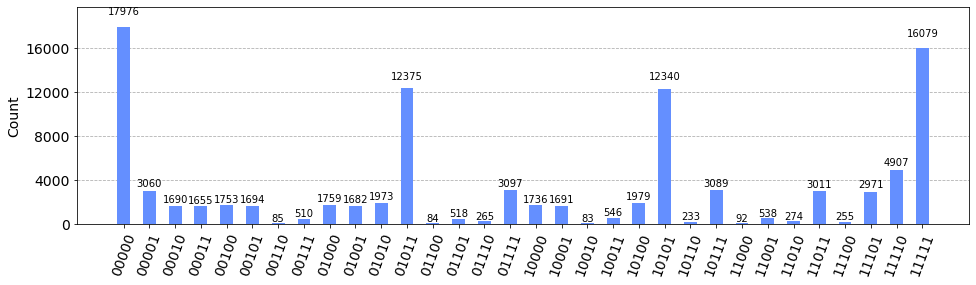

In [297]:
gamma=5
beta=2
theta = [gamma, beta]

qc=QAOA_Vertex_Cover(connections,gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 5 ,Gamma Post-Otimization: 6.870959639583798 ,Beta Pre-Otimization: 2 ,Beta Post-Optimization: 3.562265167448083


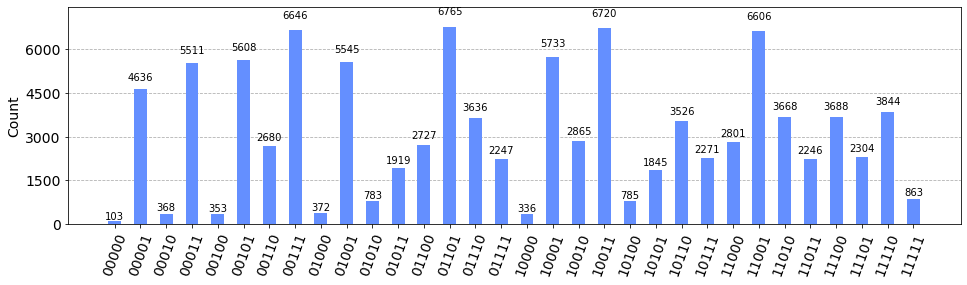

In [298]:
gamma=5
beta=2
theta = [gamma, beta]
expectation = get_expectation(g, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(connections,res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
#times["rx"][5].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(16,4))

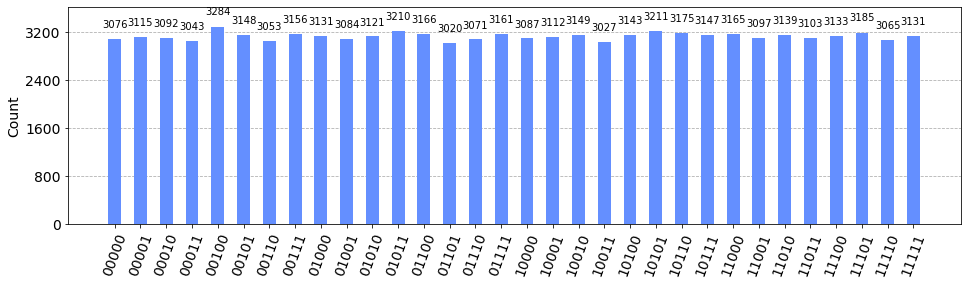

In [299]:
gamma=0
beta=0
theta = [gamma, beta]

qc=QAOA_Vertex_Cover(connections,gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 0 ,Gamma Post-Otimization: 1.0410283532545999 ,Beta Pre-Otimization: 0 ,Beta Post-Optimization: 0.3305286623617047


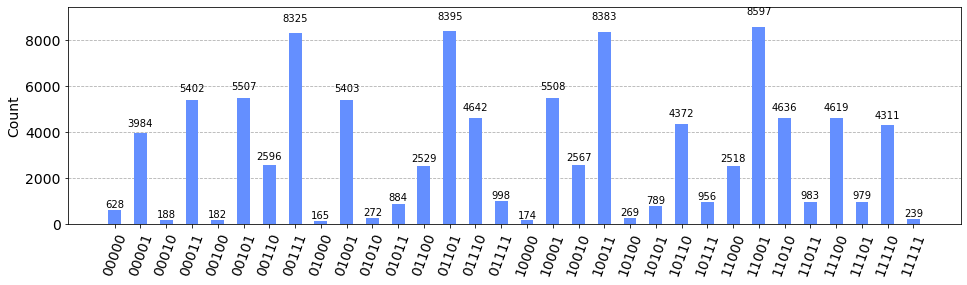

In [300]:
gamma=0
beta=0
theta = [gamma, beta]
expectation = get_expectation(g, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(connections,res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["rx"][5].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(16,4))

In [301]:
graph2_dict = {
    0: [2,4],
    1: [2],
    2: [0,1,3],
    3: [2],
    4: [0]
}
g2 = graph(graph2_dict)
print(g2.getEdges())

[[0, 2], [0, 4], [1, 2], [2, 3]]


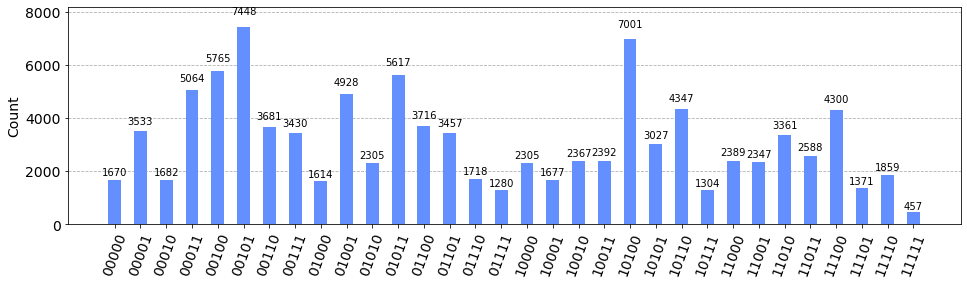

In [302]:
gamma=5
beta=3
theta = [gamma, beta]

qc=QAOA_Vertex_Cover(g2.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 5 ,Gamma Post-Otimization: 4.816219895666779 ,Beta Pre-Otimization: 3 ,Beta Post-Optimization: 2.6707057349603183


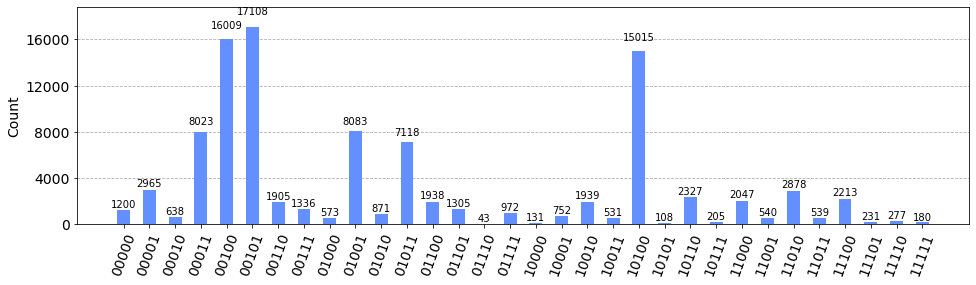

In [303]:
gamma=5
beta=3
theta = [gamma, beta]
expectation = get_expectation(g2, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(g2.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
#times["rx"][5].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(16,4))

In [304]:
graph3_dict = {
    0: [1,2],
    1: [0],
    2: [0,3],
    3: [2],
}
g3 = graph(graph3_dict)
print(g3.getEdges())

[[0, 1], [0, 2], [2, 3]]


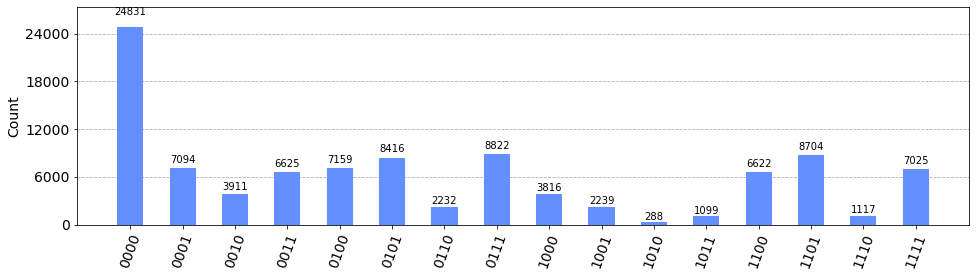

In [305]:
gamma=1
beta=1
theta = [gamma, beta]

qc=QAOA_Vertex_Cover(g3.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 1 ,Gamma Post-Otimization: 1.9826990146393282 ,Beta Pre-Otimization: 1 ,Beta Post-Optimization: 1.9395784276103887


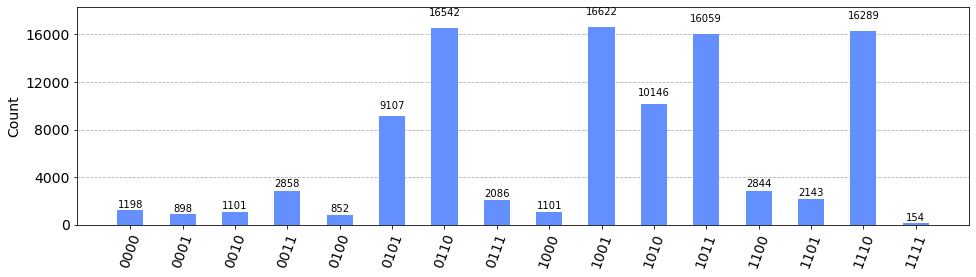

In [306]:
gamma=1
beta=1
theta = [gamma, beta]
expectation = get_expectation(g3, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(g3.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["rx"][4].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(16,4))

In [307]:
graph4_dict = {
    0: [3],
    1: [4],
    2: [5],
    3: [0,4],
    4: [1,3,5],
    5: [2,4]
}
g4 = graph(graph4_dict)
print(g4.getEdges())

[[0, 3], [1, 4], [2, 5], [3, 4], [4, 5]]


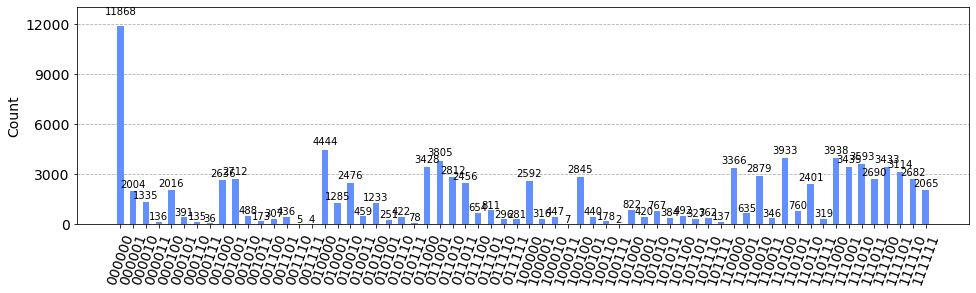

In [308]:
gamma=1
beta=1
theta = [gamma, beta]

qc=QAOA_Vertex_Cover(g4.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 1 ,Gamma Post-Otimization: 1.0791302225233252 ,Beta Pre-Otimization: 1 ,Beta Post-Optimization: 1.8535117851839702


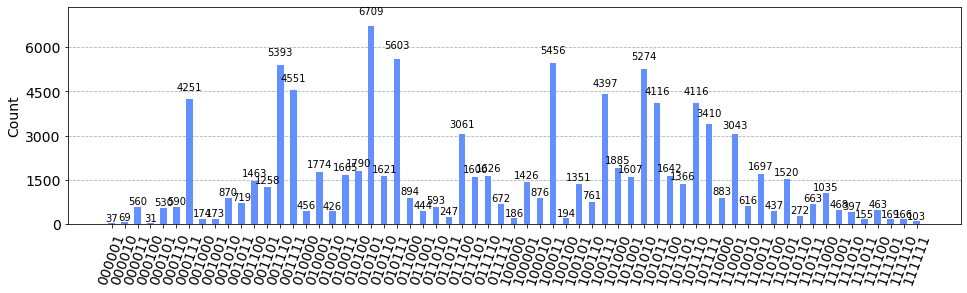

In [309]:
gamma=1
beta=1
theta = [gamma, beta]
expectation = get_expectation(g4, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(g4.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["rx"][6].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts,figsize=(16,4))

In [310]:
graph5_dict = {
    0: [1],
    1: [0,2],
    2: [1],
}
g5 = graph(graph5_dict)
print(g5.getEdges())

[[0, 1], [1, 2]]


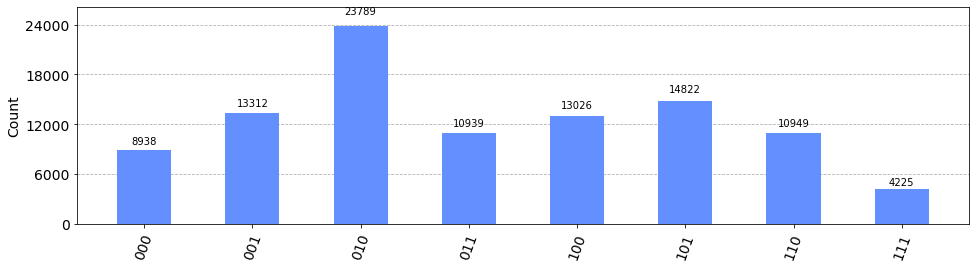

In [311]:
gamma=5
beta=3
theta = [gamma, beta]

qc=QAOA_Vertex_Cover(g5.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 5 ,Gamma Post-Otimization: 4.601012422711188 ,Beta Pre-Otimization: 3 ,Beta Post-Optimization: 2.685987327223763


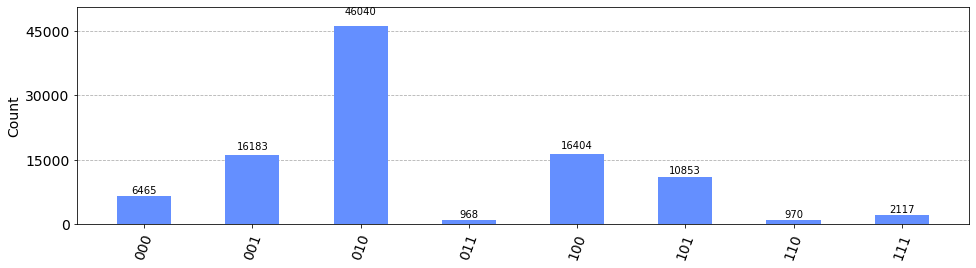

In [312]:
gamma=5
beta=3
theta = [gamma, beta]
expectation = get_expectation(g5, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(g5.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["rx"][3].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts,figsize=(16,4))

# Ry Mixer

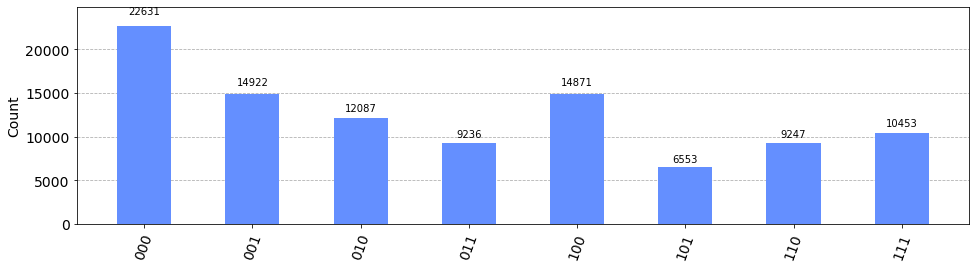

In [313]:
# 3 qubit
gamma=5
beta=3
theta = [gamma, beta]

qc=QAOA_Vertex_Cover_ry(g5.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 5 ,Gamma Post-Otimization: 6.053212109678816 ,Beta Pre-Otimization: 3 ,Beta Post-Optimization: 2.9318911399404697


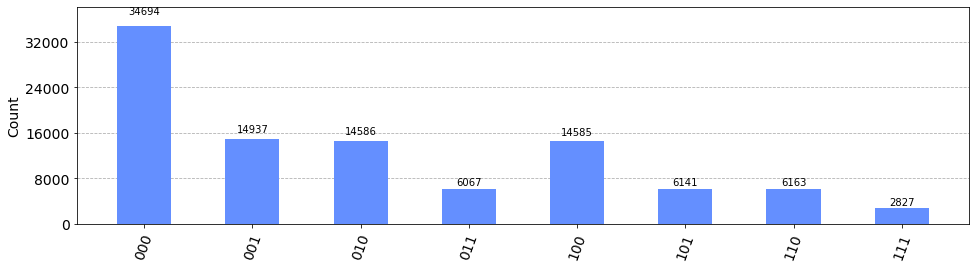

In [314]:
# 3 qubit
gamma=5
beta=3
theta = [gamma, beta]
expectation = get_expectation_ry(g5, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover_ry(g5.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["ry"][3].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts,figsize=(16,4))

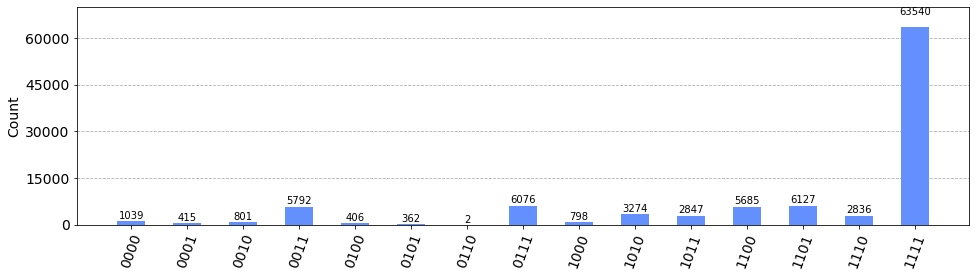

In [315]:
# 4 qubit
gamma=1
beta=1
theta = [gamma, beta]

qc=QAOA_Vertex_Cover_ry(g3.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 1 ,Gamma Post-Otimization: 2.29585043795595 ,Beta Pre-Otimization: 1 ,Beta Post-Optimization: 1.9085067324665785


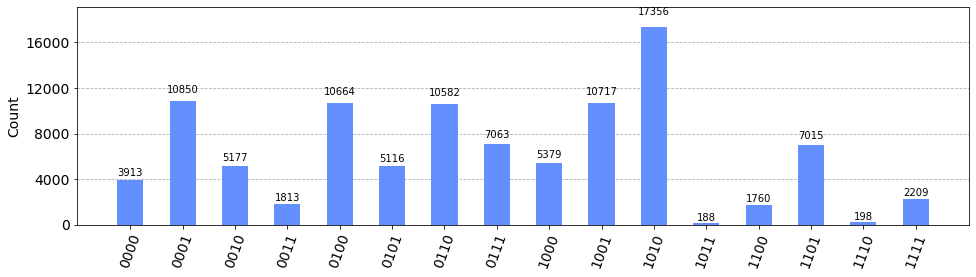

In [316]:
# 4 qubit
gamma=1
beta=1
theta = [gamma, beta]
expectation = get_expectation_ry(g3, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover_ry(g3.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["ry"][4].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(16,4))

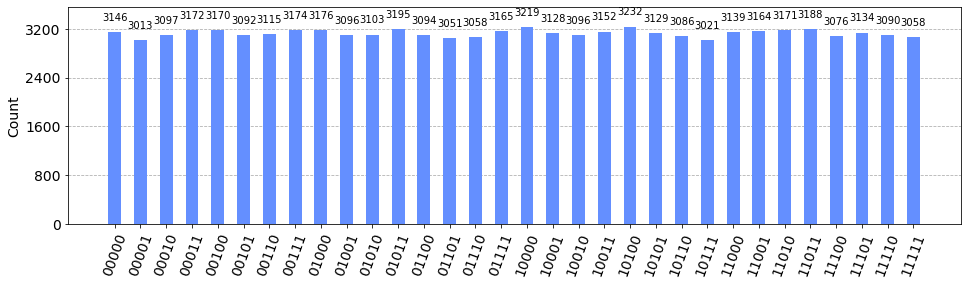

In [317]:
# 5 qubit
gamma=0
beta=0
theta = [gamma, beta]

qc=QAOA_Vertex_Cover_ry(connections,gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 0 ,Gamma Post-Otimization: 0.9999043795595616 ,Beta Pre-Otimization: 0 ,Beta Post-Optimization: -2.926997387034852e-05


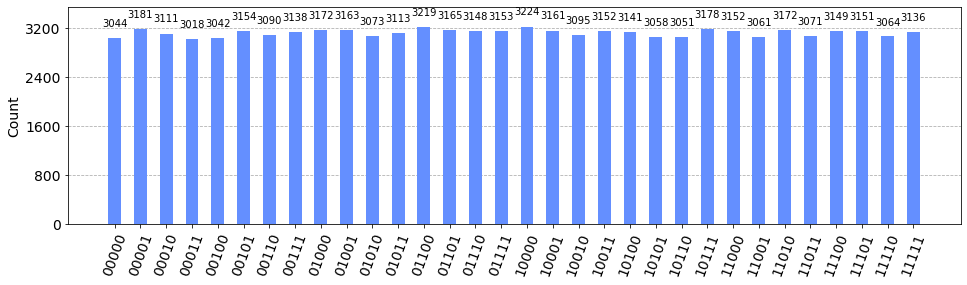

In [318]:
# 5 qubits
gamma=0
beta=0
theta = [gamma, beta]
expectation = get_expectation_ry(g, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover_ry(connections,res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["ry"][5].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(16,4))

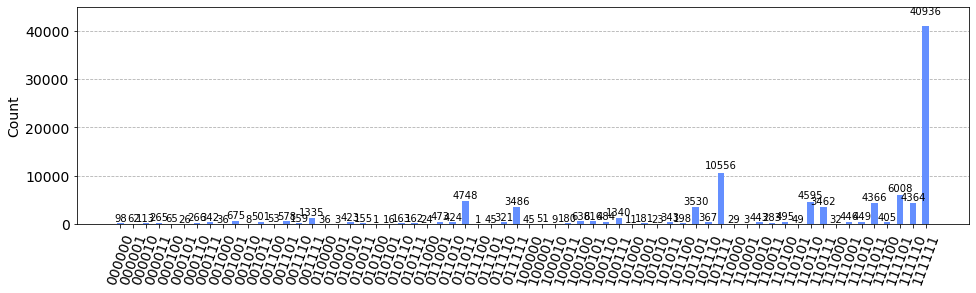

In [319]:
# 6 qubit

gamma=1
beta=1
theta = [gamma, beta]

qc=QAOA_Vertex_Cover_ry(g4.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 1 ,Gamma Post-Otimization: 2.3592169062845696 ,Beta Pre-Otimization: 1 ,Beta Post-Optimization: 1.8178105729032992


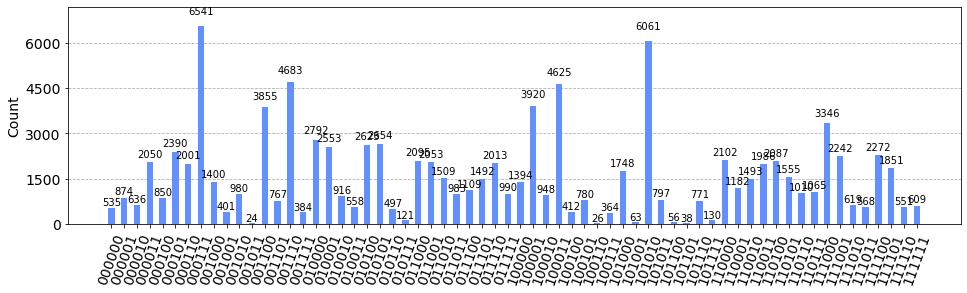

In [320]:
# 6 qubit

gamma=1
beta=1
theta = [gamma, beta]
expectation = get_expectation_ry(g4, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover_ry(g4.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["ry"][6].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts,figsize=(16,4))

# Testing on fake noisy backend

In [ ]:
simualtor = FakeToronto()

# Rx Mixer

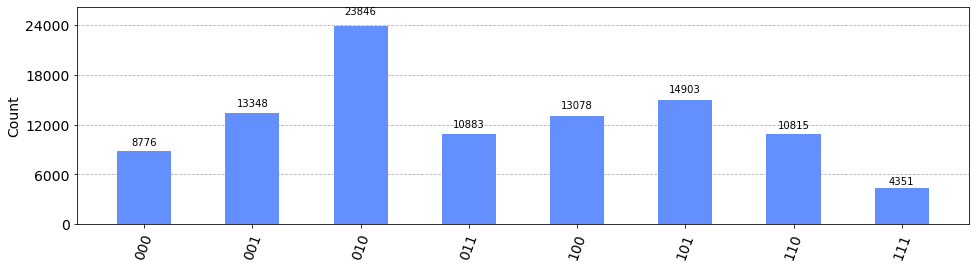

In [322]:
# 3 qubit
gamma=5
beta=3
theta = [gamma, beta]

qc=QAOA_Vertex_Cover(g5.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 5 ,Gamma Post-Otimization: 4.596940586643042 ,Beta Pre-Otimization: 3 ,Beta Post-Optimization: 2.7149113606255386


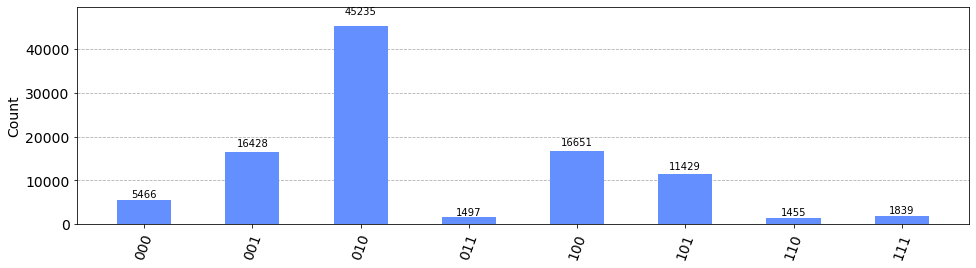

In [323]:
gamma=5
beta=3
theta = [gamma, beta]
expectation = get_expectation(g5, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(g5.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["rx"][3].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts,figsize=(16,4))

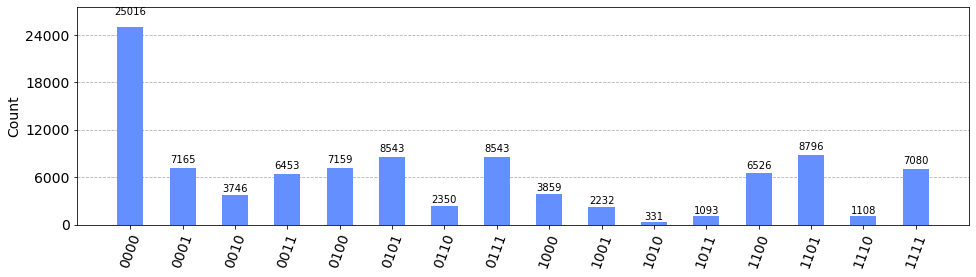

In [324]:
# 4 qubit
gamma=1
beta=1
theta = [gamma, beta]

qc=QAOA_Vertex_Cover(g3.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 1 ,Gamma Post-Otimization: 0.9214781704833136 ,Beta Pre-Otimization: 1 ,Beta Post-Optimization: 1.9334595073476997


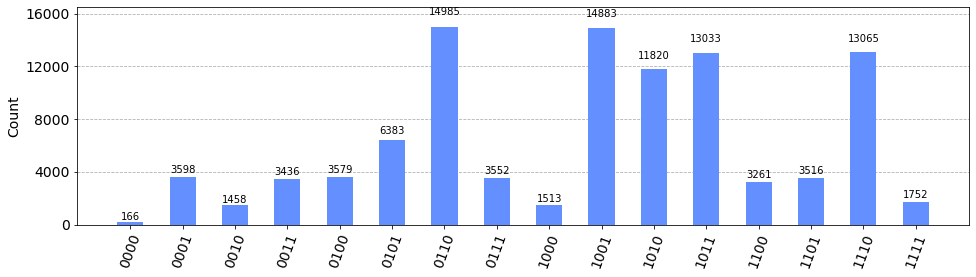

In [325]:
gamma=1
beta=1
theta = [gamma, beta]
expectation = get_expectation(g3, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(g3.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["rx"][4].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(16,4))

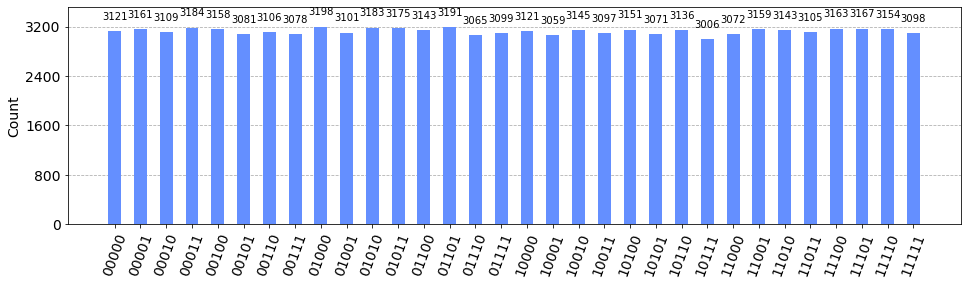

In [326]:
# 5 qubit
gamma=0
beta=0
theta = [gamma, beta]

qc=QAOA_Vertex_Cover(connections,gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 0 ,Gamma Post-Otimization: -0.7619796759017694 ,Beta Pre-Otimization: 0 ,Beta Post-Optimization: -0.35691818480078413


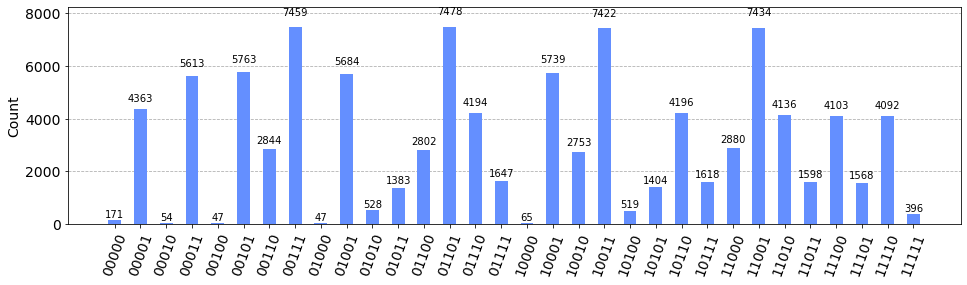

In [327]:
gamma=0
beta=0
theta = [gamma, beta]
expectation = get_expectation(g, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(connections,res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["rx"][5].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(16,4))

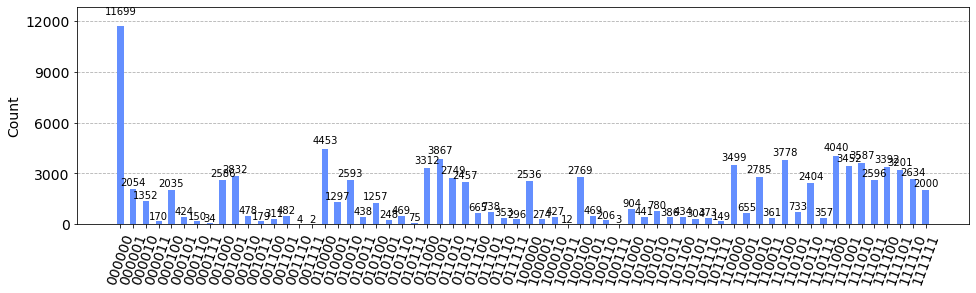

In [328]:
# 6 qubit
gamma=1
beta=1
theta = [gamma, beta]

qc=QAOA_Vertex_Cover(g4.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 1 ,Gamma Post-Otimization: 1.9915776714773692 ,Beta Pre-Otimization: 1 ,Beta Post-Optimization: 1.964842935544267


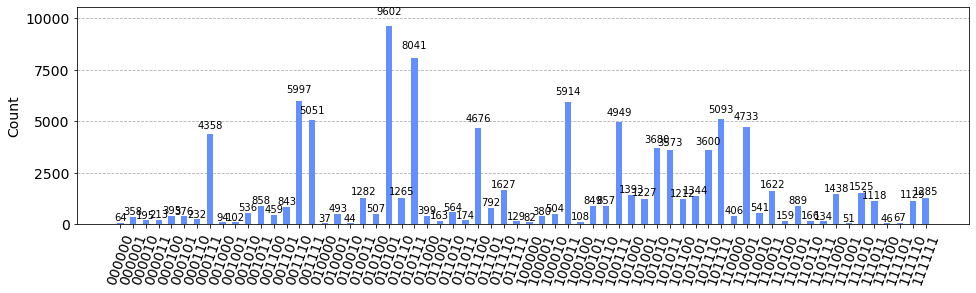

In [329]:
gamma=1
beta=1
theta = [gamma, beta]
expectation = get_expectation(g4, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(g4.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["rx"][6].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts,figsize=(16,4))

# Ry Mixer

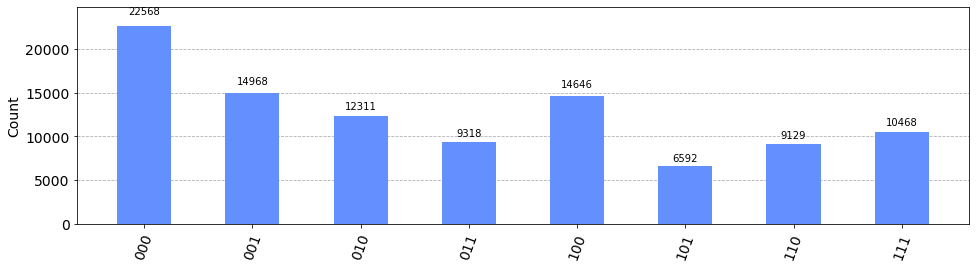

In [330]:
# 3 qubit
gamma=5
beta=3
theta = [gamma, beta]

qc=QAOA_Vertex_Cover_ry(g5.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 5 ,Gamma Post-Otimization: 6.134495321875916 ,Beta Pre-Otimization: 3 ,Beta Post-Optimization: 2.999612064815859


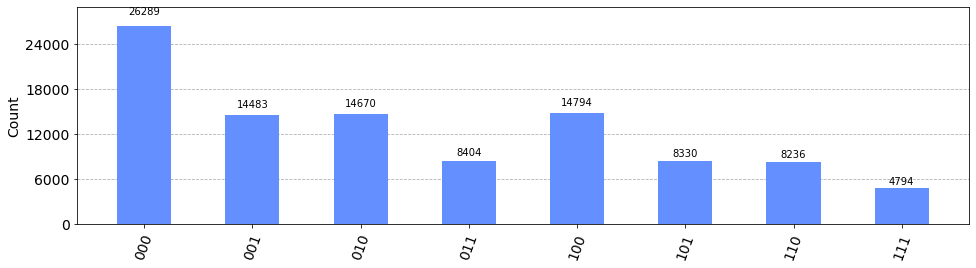

In [331]:
# 3 qubits
gamma=5
beta=3
theta = [gamma, beta]
expectation = get_expectation_ry(g5, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover_ry(g5.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["ry"][3].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts,figsize=(16,4))

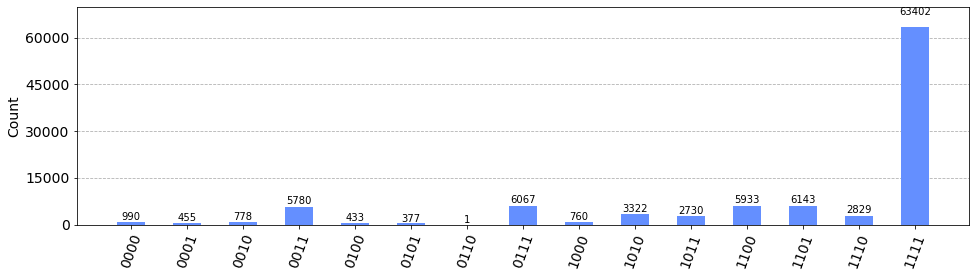

In [332]:
# 4 qubit
gamma=1
beta=1
theta = [gamma, beta]

qc=QAOA_Vertex_Cover_ry(g3.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 1 ,Gamma Post-Otimization: 2.130570081975987 ,Beta Pre-Otimization: 1 ,Beta Post-Optimization: 1.887392946008559


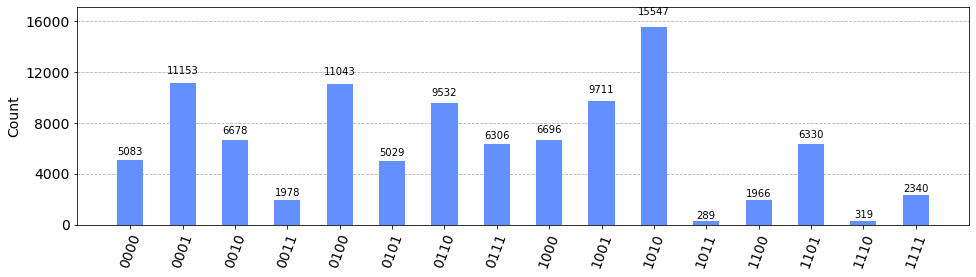

In [333]:
# 4 qubit
gamma=1
beta=1
theta = [gamma, beta]
expectation = get_expectation_ry(g3, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover_ry(g3.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["ry"][4].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(16,4))

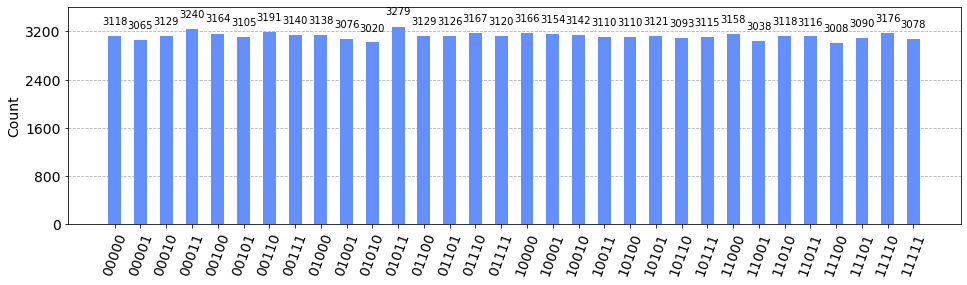

In [334]:
# 5 qubit
gamma=0
beta=0
theta = [gamma, beta]

qc=QAOA_Vertex_Cover_ry(connections,gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(20,5))

Gamma Pre-Otimization: 0 ,Gamma Post-Otimization: 0.9962654851125323 ,Beta Pre-Otimization: 0 ,Beta Post-Optimization: 0.02133261421646356


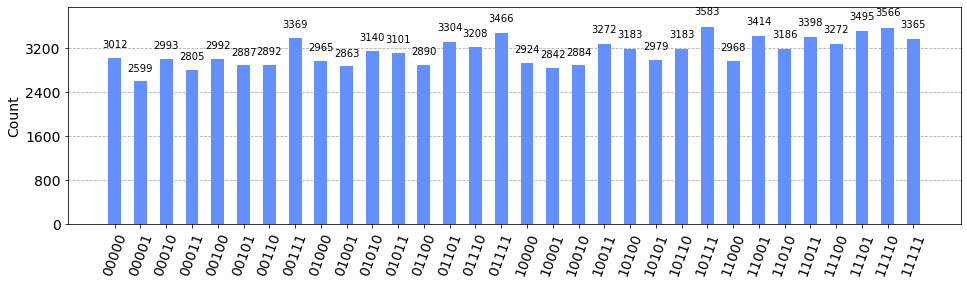

In [335]:
# 5 qubits
gamma=0
beta=0
theta = [gamma, beta]
expectation = get_expectation_ry(g, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover_ry(connections,res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["ry"][5].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(20,5))

<<<<<<< local


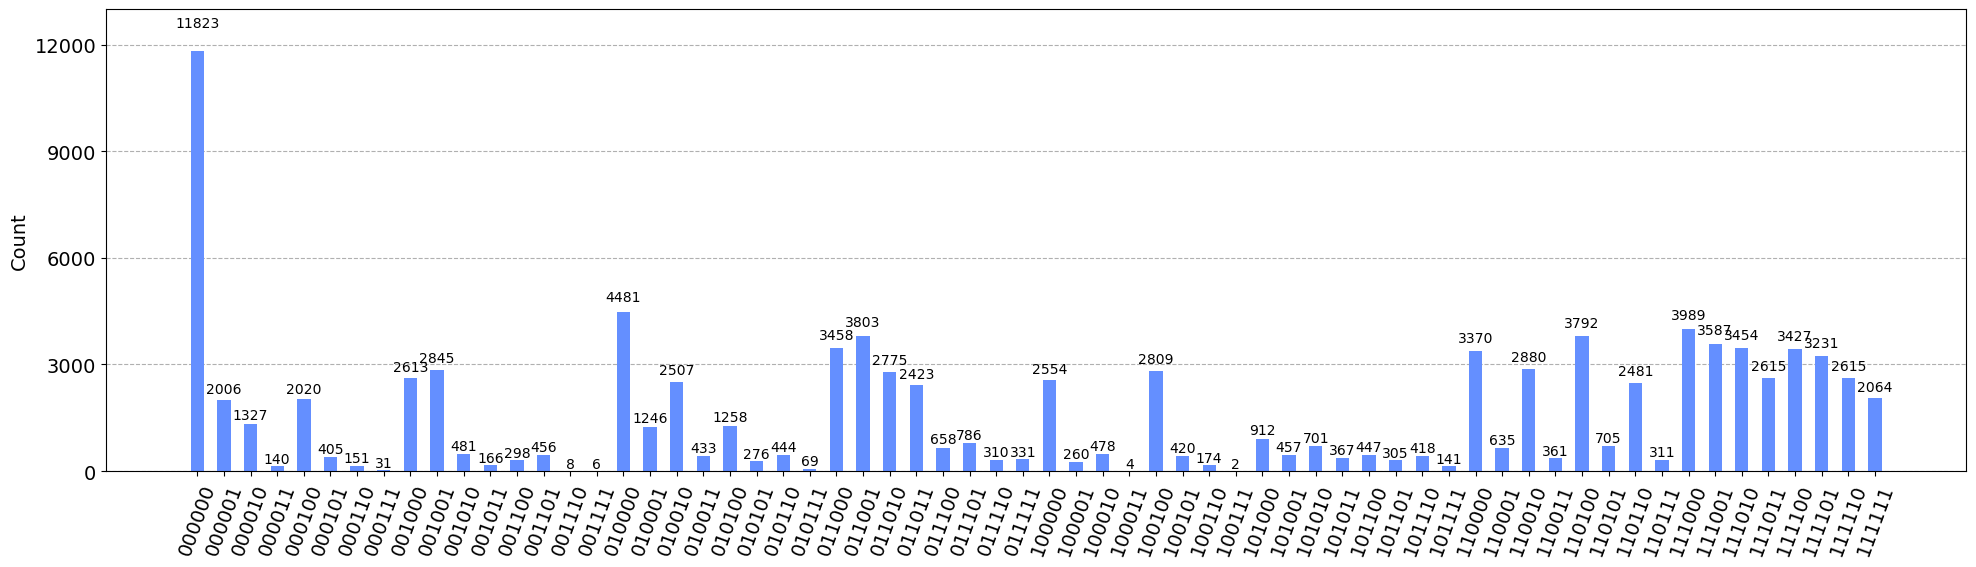

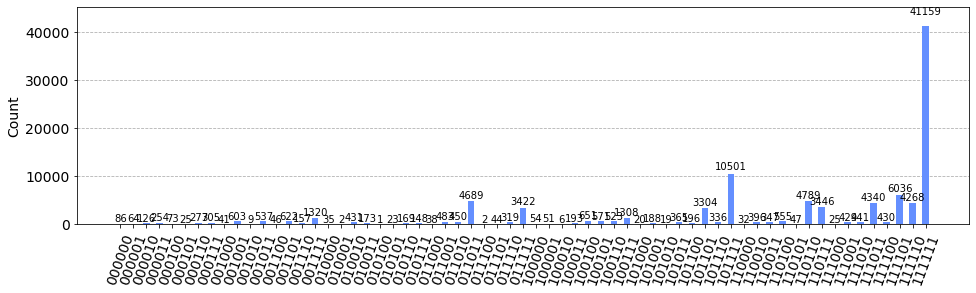

>>>>>>> remote


In [ ]:
# 6 qubit
gamma=1
beta=1
theta = [gamma, beta]

qc=QAOA_Vertex_Cover_ry(g4.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(24,6))

<<<<<<< local <modified: >


Gamma Pre-Otimization: 1 ,Gamma Post-Otimization: 1.9830474027841534 ,Beta Pre-Otimization: 1 ,Beta Post-Optimization: 1.9246752552728317


Gamma Pre-Otimization: 1 ,Gamma Post-Otimization: 2.4290566896581276 ,Beta Pre-Otimization: 1 ,Beta Post-Optimization: 1.908445557807727


>>>>>>> remote <modified: >


<<<<<<< local


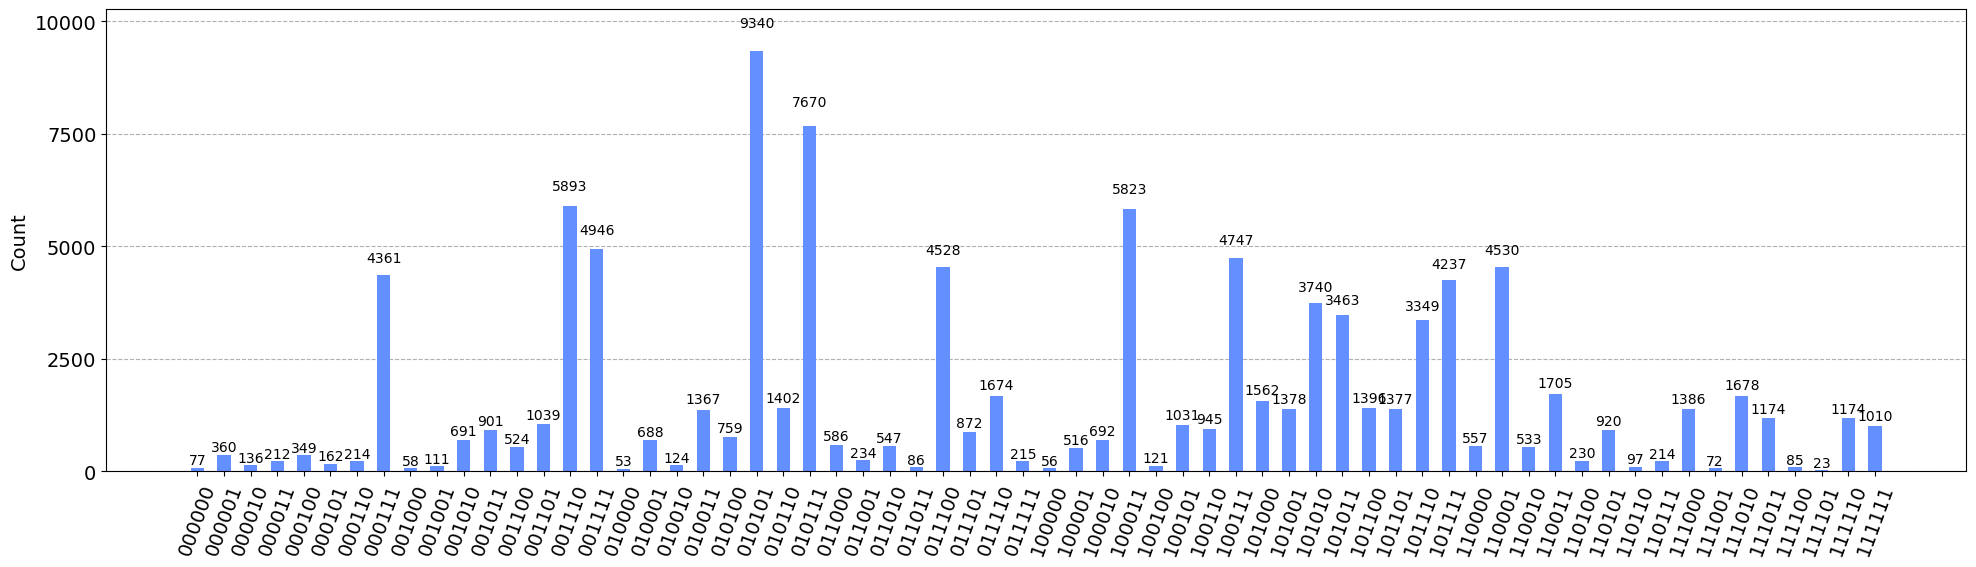

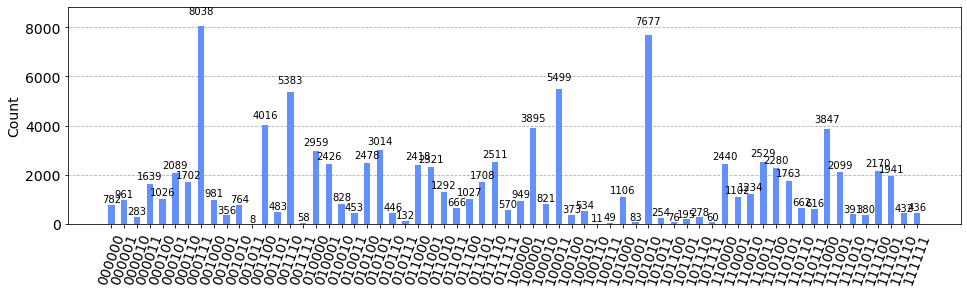

>>>>>>> remote


In [ ]:
# 6 qubit
gamma=1
beta=1
theta = [gamma, beta]
expectation = get_expectation_ry(g4, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover_ry(g4.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts

res = backend.run(circ,shots=100000).result()
times["ry"][6].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts,figsize=(24,6))


In [338]:
print(times["rx"])
print(times["ry"])

{3: [0.22395563125610352, 0.18999838829040527], 4: [0.6750009059906006, 0.6979708671569824], 5: [0.5439939498901367, 0.27300548553466797], 6: [0.3199644088745117, 0.3550400733947754]}
{3: [0.2149662971496582, 0.20096683502197266], 4: [0.4830172061920166, 0.49700021743774414], 5: [0.36803293228149414, 0.24500012397766113], 6: [0.363004207611084, 0.30699682235717773]}


# Testing on IBM quantum computer

In [339]:
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor

backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 7 and 
                                        not x.configuration().simulator and x.status().operational==True))
shots = backend.configuration().max_shots

# Rx mixer

In [340]:
# 3 qubit

gamma=5
beta=3
theta = [gamma, beta]
expectation = get_expectation(g5, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(g5.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
job = backend.run(circ,shots = shots)
job_monitor(job)
res = job.result()
times["rx"][3].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts,figsize=(16,4))

IBMQBackendApiError: "Error submitting job: '400 Client Error: Bad Request for url: https://api-qcon.quantum-computing.ibm.com/api/Network/ibm-q/Groups/open/Projects/main/Jobs. Error wrong data received., Error code: 2400.'"

In [ ]:
# 4 qubit

gamma=1
beta=1
theta = [gamma, beta]
expectation = get_expectation(g3, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(g3.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
job = backend.run(circ,shots = shots)
job_monitor(job)
res = job.result()
times["rx"][4].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(16,4))

In [ ]:
# 5 qubit

gamma=0
beta=0
theta = [gamma, beta]
expectation = get_expectation(g, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(connections,res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
job = backend.run(circ,shots = shots)
job_monitor(job)
res = job.result()
times["rx"][5].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(20,5))

In [ ]:
# 6 qubit

gamma=1
beta=1
theta = [gamma, beta]
expectation = get_expectation(g4, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(g4.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
job = backend.run(circ,shots = shots)
job_monitor(job)
res = job.result()
times["rx"][6].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts,figsize=(24,6))


# Ry Mixer

In [ ]:
# 3 qubit

gamma=5
beta=3
theta = [gamma, beta]
expectation = get_expectation_ry(g5, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover_ry(g5.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
job = backend.run(circ,shots = shots)
job_monitor(job)
res = job.result()
times["ry"][3].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts,figsize=(16,4))

In [ ]:
# 4 qubit

gamma=1
beta=1
theta = [gamma, beta]
expectation = get_expectation_ry(g3, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover_ry(g3.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
job = backend.run(circ,shots = shots)
job_monitor(job)
res = job.result()
times["ry"][4].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(16,4))

In [ ]:
# 5 qubit

gamma=0
beta=0
theta = [gamma, beta]
expectation = get_expectation_ry(g, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover_ry(connections,res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts

job = backend.run(circ,shots = shots)
job_monitor(job)
res = job.result()
times["ry"][5].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(20,5))

In [ ]:
# 6 qubit

gamma=1
beta=1
theta = [gamma, beta]
expectation = get_expectation_ry(g4, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover_ry(g4.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts

job = backend.run(circ,shots = shots)
job_monitor(job)
res = job.result()
times["ry"][6].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(24,6))
